# Multiprocessing between nodes using MPI

MOTIVATION

* ?

LEARNING OUTCOMES

* ?

## Introduction

DISTRIBUTING WORK OVER CORES OF ONE MACHINE USING MULTIPROCESSING/MULTITHREADING ONLY SCALES SO FAR

WHAT IF HAVE A PROBLEM THAT COULD EFFICIENTLY SCALE TO MORE CPUS THAN HAVE IN A SINGLE MACHINE?

wHAT IF HAVE A PROBLEM WHERE NEED MORE MEMORY PER CORE THAN HAVE IN A SINGLE MACHINE?

WANT TO LOOK AT DISTRIBUTING WORK *BETWEEN* MACHINES

FOR YEARS DE-FACTO STANDARD FOR THIS IN RESEARCH COMPUTING ENVIRONMENTS HAS BEEN MPI

-> MESSAGE PASSING INTERFACE

START A SINGLE PROGRAM MULTIPLE TIMES TO GIVE N PROCESSES.  MAY BE ON SINGLE MACHINE OR DISTRIBUTED BETWEEN MACHINES.

THAT SINGLE PROGRAM INCLUDES LOGIC EXECUTED BY ALL PROGRAMS BUT SPECIFY LOGIC FOR SUBSETS OF PROCESSES OR SINGLE PROCESSES USING CONDITIONALS E.G. in pseudocode:

```python
# Get the 'rank' (MPI process ID) of _this_ process
rank = get_mpi_rank()

# Done for all ranks 
print("Hello from rank {}".format(rank))

# Do different things based on rank 
if rank == 0:
    print("I am the boss (rank = {})".format(rank))
else:
    print("I am a lowly worker (rank = {})".format(rank))
```

THESE PROCESSES CAN PASS MESSAGES (DATA AND CONTROL) INFORMATION BETWEEN EACH OTHER.

---

## Computing the Mandelbrot set

Let's look at a problem that can be parallelised using MPI. 

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is a set of numbers on a [complex](https://en.wikipedia.org/wiki/Complex_number) plane.  
Each pixel is calculated independently using a function that takes its coordinates in that plane (a complex number) 
and transforms it into an integer by an iterative method. 
The number of iterations required vary with the input to the function.
If you treat the integer output as the pixel color for a 2D bitmap you get:  

<img src="static/mandelbrot-example.png" alt="Mandelbrot set visualised" />

Let's start by looking at some serial code for computing the Mandelbrot set (based on the C code in [Wilkinson, B. and Allen, M. (1999)](README.md#further-reading)).  Here is the function for mapping a complex to an integer: 

In [159]:
def calc_pixel(c):
    """Calculate the Mandelbrot set (integer) value for a given complex number."""

    z = complex(0, 0)
    count = 0  # Number of iterations
    max_ = 256  # Maximum number of iterations
    
    while True:
        temp = (z.real ** 2) - (z.imag ** 2) + c.real
        z_imag = 2 * z.real * z.imag + c.imag
        z = complex(temp, z_imag)
        
        length_sq = (z.real ** 2) + (z.imag ** 2) 
        
        count += 1
        
        if (length_sq >= 4.0 or count >= max_):
            break
            
    return count

Next, let's calculate the Mandelbrot set for a given complex plane and visualise that as a bitmap using Matplotlib.  Note that this code and the `calc_pixel` function could be further optimised without parallelisation but we will not do that here.

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import floor
%matplotlib inline

In [164]:
# The 'screen' size (width and height) of our bitmap 
long_edge = 1000

# To store our output image
img = np.zeros((long_edge, long_edge), dtype=np.int)

# Minimum values in our complex plane
min_ = complex(-1.6, -1.5)
# Scaling between inputs and display
scale = complex(2.2, 3.) / long_edge

In [165]:
# For each pixel
for i in range(long_edge):
    for j in range(long_edge):
        # Identify the complex value on the complex plane that corresponds to this pixel
        c = complex(min_.real + (i * scale.real), 
                    min_.imag + (j * scale.imag))
        # Find and save the integer value for that pixel
        img[i, j] = calc_pixel(c)

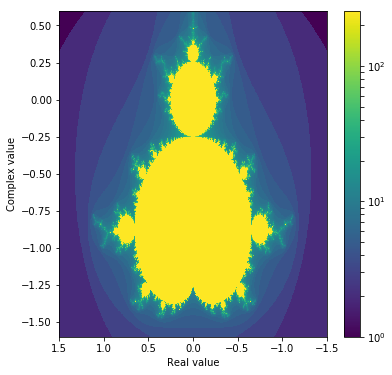

In [166]:
# Visualise the output as a bitmap, 
# ensuring that the axes are labelled in terms of the complex domain
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.imshow(img, 
          extent=[min_.imag + scale.imag * long_edge, 
                  min_.imag,
                  min_.real, 
                  min_.real + scale.real * long_edge],
          aspect='auto',
          norm=LogNorm())
ax.set_xlabel('Real value')
ax.set_ylabel('Complex value')
fig.colorbar(cax);

## Computing the Mandelbrot set in parallel

The Mandelbrot set is well-suited to parallelisation as the value per pixel can be computed independently - the problem is *embarassingly parallel*.

One approach if using MPI is for 

1. A master process to **divide up the complex plane** into a region for each available worker process (possibly also counting itself as a worker process);
2. The master process to **send out complex coordinates** to worker processes using MPI;
3. Each worker process **calculate the integer outputs** for its own coordinate range;
4. Each worker uses MPI to **send its portion of the results back** to the master process for aggregation and plotting.

In [172]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
rank

0

In [173]:
if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    data = comm.recv(source=0, tag=11)

Exception: Invalid rank, error stack:
MPI_Send(173): MPI_Send(buf=0x562396986960, count=35, MPI_BYTE, dest=1, tag=11, MPI_COMM_WORLD) failed
MPI_Send(98).: Invalid rank has value 1 but must be nonnegative and less than 1